In [1]:
import chess.pgn
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry_convert
from geopy.geocoders import Nominatim
import folium
import cartopy.crs as ccrs
from tqdm import tqdm

In [2]:
pgn = open("caissabase.pgn") # DB containing ~4 million chess games

In [3]:
death_squares = {}
kills_by_piece = {}
pbar = tqdm(total=4000000) # set up progress bar

# parse all games
while True:
    try: # read in game
        game = chess.pgn.read_game(pgn) 
        board = game.board()
    except: # if no game is left
        break
    
    # loop through all moves in this game
    for move in game.mainline_moves(): 
        if 'x' in board.san(move): # if this is a capturing move, append to kill_moves
            xi = board.san(move).index('x') # find index for 'x'
            
            try: # increment death toll for this particular square
                death_squares[board.san(move)[xi+1] + board.san(move)[xi+2]] += 1
            except: # create dict entry for this particular square
                death_squares.update({board.san(move)[xi+1] + board.san(move)[xi+2]: 1})
            
            # if this kill was done by a pawn
            if ((board.san(move)[xi-1].islower()) and (not board.san(move)[xi-1].isnumeric())):
                try:
                    kills_by_piece['P'] += 1
                except:
                    kills_by_piece.update({'P': 1})
                    
            elif (not board.san(move)[xi-1].isnumeric()):
                try:
                    kills_by_piece[board.san(move)[xi-1]] += 1
                except:
                    kills_by_piece.update({board.san(move)[xi-1]: 1})

        board.push(move) # next move
            
    pbar.update(1) # update progress bar
    
pbar.close() # close progress bar

dic = collections.Counter(death_squares)
dic = collections.OrderedDict(sorted(dic.items()))      

chessboard = np.array(list(dic.values()) ).reshape(8,8) # transform to 2D numpy array
chessboard = chessboard.transpose() # transpose (swap rows with columns)
chessboard = np.flipud(chessboard)  # flip vertically to match chessboard layout     

df = pd.DataFrame(data=chessboard, 
                  index=["8", "7", "6", "5", "4", "3", "2", "1"], 
                  columns=["a", "b", "c", "d", "e", "f", "g", "h"])

 97%|█████████▋| 3874617/4000000 [22:52:32<47:18, 44.18it/s]   error during pgn parsing
Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/__init__.py", line 2932, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/pgn.py", line 1651, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/pgn.py", line 1032, in parse_san
    return board.parse_san(san)
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/__init__.py", line 2934, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r3k3/1R1b2p1/r7/

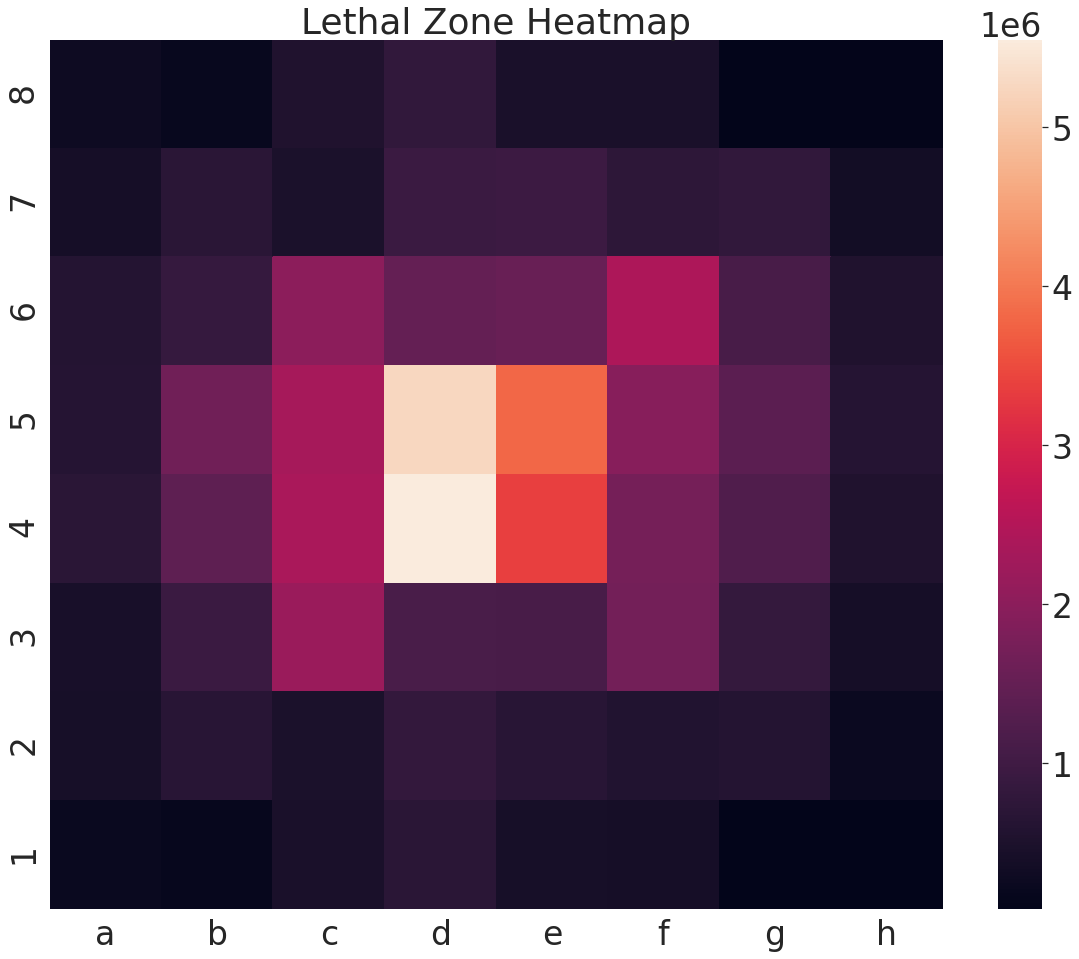

In [10]:
# configure and plot heatmap
fig, ax = plt.subplots(figsize=(20,16))
sns.set(font_scale = 3)
ax.set_title('Lethal Zone Heatmap')
ax = sns.heatmap(df, linewidths=0)
plt.savefig('fig/heatmap1.png')
plt.show()

In [11]:
# convert dict to numpy array
temp = np.array(list(kills_by_piece.values()) )
# convert numpy array to dataframe for easier use with seaborn
captures_df = pd.DataFrame(data=temp, 
                  columns=["Captures"], 
                  index=["Bishop", "Queen", "Knight", "Rook", "King", "Pawn"])

captures_df = captures_df.transpose()
captures_df

,Bishop,Queen,Knight,Rook,King,Pawn
Captures,21189762,12247048,9508638,11300974,11806315,2798702


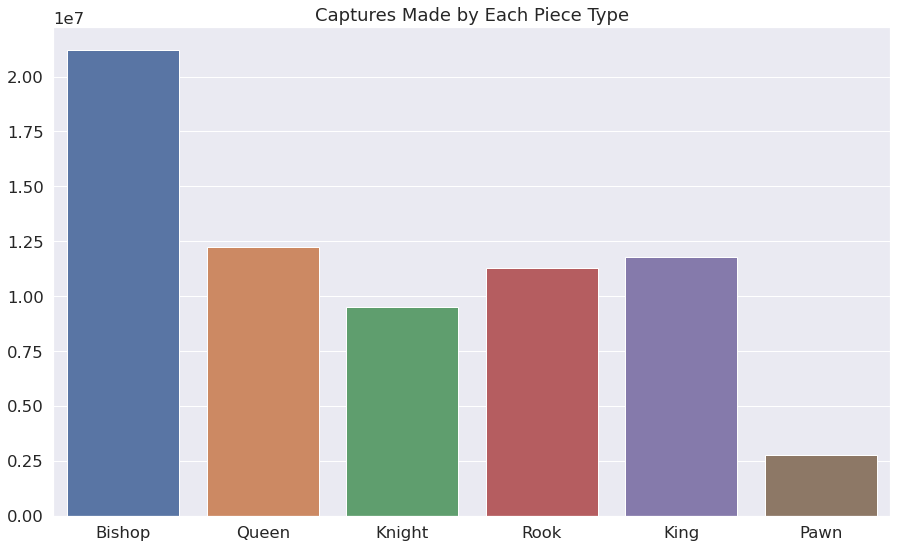

In [13]:
# configure and plot bar chart
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Captures Made by Each Piece Type')
sns.set(font_scale = 1.5)
ax1 = sns.barplot(data=captures_df)
plt.savefig('fig/barplot1.png')
plt.show()

In [15]:
# The number of captures a piece is able to make is dependent on how many pieces there are.
# To normalize, I divide each capture score by the number of pieces for each piece type.
captures_df.at["Captures", "Bishop"] = captures_df.at["Captures", "Bishop"] / 2
captures_df.at["Captures", "Knight"] = captures_df.at["Captures", "Knight"] / 2
captures_df.at["Captures", "Rook"] = captures_df.at["Captures", "Rook"] / 2
captures_df.at["Captures", "Pawn"] = captures_df.at["Captures", "Pawn"] / 8

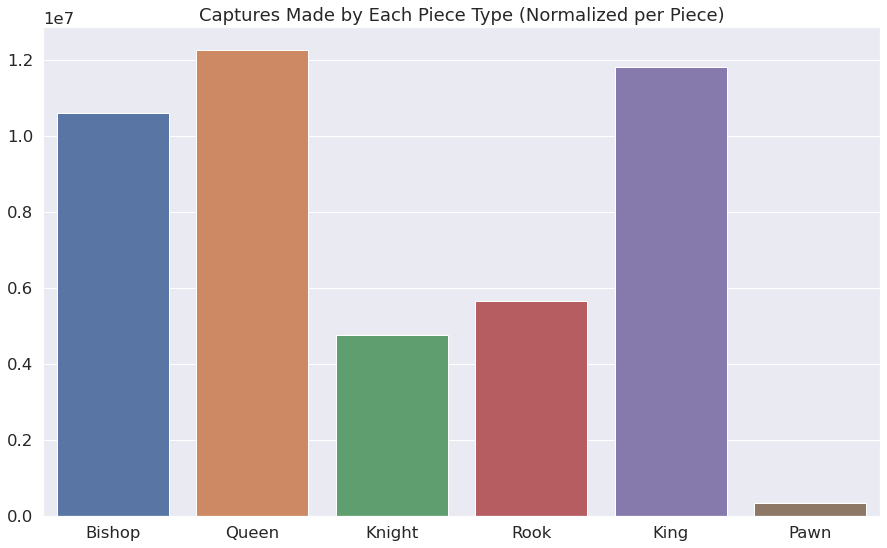

In [16]:
# configure and plot normalized bar chart
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Captures Made by Each Piece Type (Normalized per Piece)')
sns.set(font_scale = 1.5)
ax1 = sns.barplot(data=captures_df)
plt.savefig('fig/barplotnormalized1.png')
plt.show()

In [19]:
# # VISUALIZATION 1----------------------------------------------------HEATMAP OF LETHAL ZONES
# kill_moves = []    # store killing moves (containing 'x')
# death_squares = [] # store square positions where captures occured
# pbar = tqdm(total=4000000) # set up progress bar

# # parse all games
# for i in range(0,100):
#     game = chess.pgn.read_game(pgn) # read in game
#     board = game.board()
    
#     # loop through all moves in this game
#     for move in game.mainline_moves(): 
#         if 'x' in board.san(move): # if this is a capturing move, append to kill_moves
#             kill_moves.append(board.san(move))
#         board.push(move) # next move
#     pbar.update(1) # update progress bar
    
# pbar.close() # close progress bar


# #----------------------------------------------------------------------------------------
# # Here I find the capture position for each capture move.
# # The 2-character position always follows after the 'x', 
# # so I can generalize and obtain it by concatenating
# # the characters at [index(x)+1] and [index(x)+2]
# for elem in kill_moves:
#     xi = elem.index('x') # find index for 'x'
#     death_squares.append(elem[xi + 1] + elem[xi + 2]) # get position and append to list

# # get capture occurrences for each square and store them in a dictionary
# dic = collections.Counter(death_squares)
# # sort keys alphabetically and numerically (a1,a2,...,h7,h8)
# dic = collections.OrderedDict(sorted(dic.items()))      


# #-------------------------------------------------------------------------------------
# chessboard = np.array(list(dic.values()) ).reshape(8,8) # transform to 2D numpy array
# chessboard = chessboard.transpose() # transpose (swap rows with columns)
# chessboard = np.flipud(chessboard)  # flip vertically to match chessboard layout     
    
# #-------------------------------------------------------------------------------------    
# # convert numpy array to dataframe for easier use with seaborn
# df = pd.DataFrame(data=chessboard, 
#                   index=["8", "7", "6", "5", "4", "3", "2", "1"], 
#                   columns=["a", "b", "c", "d", "e", "f", "g", "h"])       
        
        
# #-------------------------------------------------------------------------------------     
# # configure and plot heatmap
# fig, ax = plt.subplots(figsize=(20,16))
# sns.set(font_scale = 3)
# ax.set_title('Lethal Zone Heatmap')
# ax = sns.heatmap(df, linewidths=0)
# plt.savefig('fig/heatmap.png')
# plt.show()

  0%|          | 100/4000000 [00:02<23:04:36, 48.15it/s]


array([[  7,   7,  17,  16,   9,  11,   4,   2],
       [ 10,  22,  15,  42,  21,  14,  11,   5],
       [ 27,  21,  39,  47,  28,  69,  23,  13],
       [ 12,  49,  73,  92, 113,  46,  30,  14],
       [ 20,  38,  43, 125,  95,  40,  31,  11],
       [ 16,  26,  32,  26,  34,  46,  19,  19],
       [ 10,  11,  11,  31,  14,  30,  17,  13],
       [  4,   8,  11,  17,   9,  19,   1,   5]])